In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
df_test = pd.read_csv("test.csv")

In [5]:
df_test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [6]:
df["day"].value_counts()

day
6      7
7      7
8      7
9      7
22     7
      ..
344    5
345    5
363    5
364    5
365    5
Name: count, Length: 365, dtype: int64

In [7]:
df.shape

(2190, 13)

### Drop id
id has unique values for each training data. It has no effect on rainfall outcome.

In [8]:
df.drop("id", axis=1, inplace=True)

### Test data

follow the same for test data

In [9]:
ids = df_test["id"]

In [10]:
df_test.drop("id", axis=1, inplace=True)

In [11]:
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [12]:
df.isnull().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

### No null values

That's great.

In [13]:
df_test.isnull().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [14]:
df_test['winddirection'].fillna(df_test['winddirection'].median(), inplace=True)

C:\Users\amogn\AppData\Local\Temp\ipykernel_19692\2387756837.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['winddirection'].fillna(df_test['winddirection'].median(), inplace=True)


In [15]:
num_duplicates = df.duplicated().sum()
print(num_duplicates)

0


### No duplicates

That's great

In [16]:
num_duplicates_test = df_test.duplicated().sum()
print(num_duplicates_test)

0


In [17]:
df.corr()['rainfall']

day             -0.000462
pressure        -0.049886
maxtemp         -0.079304
temparature     -0.049660
mintemp         -0.026841
dewpoint         0.081965
humidity         0.454213
cloud            0.641191
sunshine        -0.555287
winddirection   -0.006939
windspeed        0.111625
rainfall         1.000000
Name: rainfall, dtype: float64

Day and winddirection have very low correlation with rainfall. They can be dropped.

In [18]:
df["day_group"] = np.select([
    df["day"].between(1, 90),
    df["day"].between(91, 180),
    df["day"].between(181, 270),
    df["day"].between(271, 365),
], ["season 1", "season 2", "season 3", "season 4"], default="season 4")

In [19]:
df[["rainfall", "day_group"]].groupby(["day_group"], as_index=False).mean().sort_values(by="rainfall", ascending=False)

,day_group,rainfall
1,season 2,0.805100
3,season 4,0.784926
0,season 1,0.745520
2,season 3,0.677180


In [20]:
df.replace({"season 2": 3, "season 4": 2, "season 1": 1, "season 3": 0}, inplace=True)

C:\Users\amogn\AppData\Local\Temp\ipykernel_19692\3801425105.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"season 2": 3, "season 4": 2, "season 1": 1, "season 3": 0}, inplace=True)


In [21]:
df.corr()['rainfall']

day             -0.000462
pressure        -0.049886
maxtemp         -0.079304
temparature     -0.049660
mintemp         -0.026841
dewpoint         0.081965
humidity         0.454213
cloud            0.641191
sunshine        -0.555287
winddirection   -0.006939
windspeed        0.111625
rainfall         1.000000
day_group        0.109224
Name: rainfall, dtype: float64

In [22]:
df.drop(['day', 'winddirection'], axis=1, inplace=True)

In [23]:
df_test["day_group"] = np.select([
    df_test["day"].between(1, 90),
    df_test["day"].between(91, 180),
    df_test["day"].between(181, 270),
    df_test["day"].between(271, 365),
], [1, 3, 0, 2], default=4)

### Test data

follow the same for test data

In [24]:
df_test.drop(['day', 'winddirection'], axis=1, inplace=True)

In [25]:
df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,rainfall,day_group
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,17.2,1,1
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,21.9,1,1
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,18.1,1,1
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,35.6,1,1
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,24.8,0,1


In [26]:
df_test.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,day_group
0,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,24.3,1
1,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,35.3,1
2,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,16.9,1
3,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,50.6,1
4,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,19.4,1


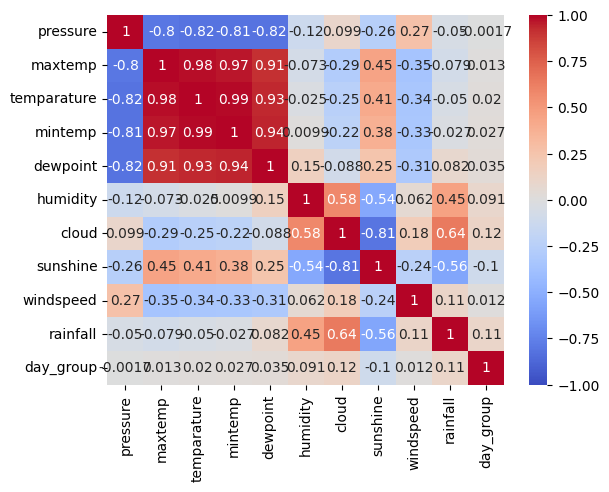

In [27]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.show()

### Feature Engineering

We can engineer new features with humidity, cloud, and sunshine values.

#### Humidity-Cloud-Sunshine interaction:
More clouds and high humidity together increase the chances of rainfall.

humidity * cloud / sunshine

Let's add sunshine into this interaction: (humidity * cloud) / sunshine

#### Cloud-Sunshine-Pressure ratio: 
If sunshine is very low and cloud cover is high, it's more likely to rain.

cloud * pressure / (sunshine + 0.000001): 0.000001 to avoid dividing by 0.

#### Rainfall Intensity: 
If clouds are high, humidity is high, sunshine is low, chances of ranfall are high.

(cloud * humidity) / (sunshine + 0.000001)

We can engineer new features with temperature, pressure, and cloud.

#### Pressure-Temperature interaction:
High temperature + Low pressure -> Rainfall likelihood increases

pressure * temperature

#### Pressure drop indicator: 
A sudden drop in atmospheric pressure often signals incoming storms or rainfall.

pressure.diff().

positive values -> stable weather

negative values -> possible rainfall

#### Temperature variability: 
Larger temperature swings can indicate unstable atmospheric conditions, leading to rainfall..

maxtemp - mintemp

#### Cloud-Temperature interaction
More clouds reduce daytime heating but night warmer. This can impact humidty, pressure, and ultimately rainfall

cloud * temperature

#### Dewpoint and cloud:
If dewpoint is high and cloud cover is high, the air is likely to retain moisture, leading to rain. Low dewpoint with high cloud → Could indicate dry clouds (cirrus) with no rain.

dewpoint * cloud

#### Pressure-windspeed:
Low pressure + High windspeed = Stormy weather (rain likely). High pressure + High windspeed = Dry & windy conditions (low rain). Low wind + Low pressure = Still air → Heavy rain or fog.

pressure / (windspeed + 0.000001)

#### Pressure-cloud:
High cloud cover + Low pressure = Heavy cloud buildup → Rain. High cloud cover + High pressure = Non-rainy clouds (stratus, cirrus, etc.).  Low cloud cover + Low pressure = Possible storms if windspeed is high.

cloud / pressure

#### Wind-Humidity
Storm winds contain moisture

windspeed * humidity

#### Season-Humidity
Humidity changes by season; higher humidity can mean more rain.

day_group * humidity

#### Season-Temp
Temperature fluctuations impact rainfall patterns (hotter seasons may have more evaporation & storms).

day_group * temparature

#### Season-Pressure
Low-pressure systems are seasonal and trigger rainfall.

day_group * pressure

#### Season-Cloud

day_group * cloud

#### Cloud-Humidity interaction:

cloud / humidity

#### Temperature-Sunshine

temp / sunshine

#### Dewpoint-Humidity-Sunshine

dew * humidity / sunshine

#### Dewpoint-Humidity

dew * humidity

#### Cloud-Humidity-Pressure

cloud * humidity / pressure

In [28]:
df["humidity-cloud-sunshine"] = (df["humidity"] * df["cloud"]) / (df["sunshine"] + 1e-6)
df["cloud/sunshine"] = df["cloud"] / (df["sunshine"] + 1e-6)
df["rainfall-intensity"] = (df["cloud"] * df["humidity"]) * (df["sunshine"] + 1e-6)

In [29]:
df["pressure-temp"] = df["pressure"] * df["temparature"]
df["pressure-drop"] = df["pressure"].diff()
df["temp-variability"] = df["maxtemp"] - df["mintemp"]
df["cloud-temp"] = df["cloud"] * df["temparature"]

In [30]:
df["dewpoint-cloud"]= df["dewpoint"] * df["cloud"]

In [31]:
df["pressure-windspeed"] = df["pressure"] / (df["windspeed"] + 1e-6)

In [32]:
df["pressure-cloud"] = df["cloud"] / (df["pressure"] + 1e-6)
df["wind-humidity"] = df["windspeed"] * df["humidity"]

In [33]:
df["season-humidity"] = df["day_group"] * df["humidity"]
df["season-temp"] = df["day_group"] * df["temparature"]
df["season-pressure"] = df["day_group"] * df["pressure"]
df["season-cloud"] = df["day_group"] * df["cloud"]

In [34]:
df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,rainfall,...,temp-variability,cloud-temp,dewpoint-cloud,pressure-windspeed,pressure-cloud,wind-humidity,season-humidity,season-temp,season-pressure,season-cloud
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,17.2,1,...,1.3,1812.8,1707.2,59.151159,0.086495,1496.4,87.0,20.6,1017.4,88.0
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,21.9,1,...,0.4,1537.9,1401.4,46.552509,0.089259,2080.5,95.0,16.9,1019.5,91.0
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,18.1,1,...,4.8,756.7,437.1,56.580107,0.045894,1357.5,75.0,16.1,1024.1,47.0
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,35.6,1,...,1.2,1691.0,1596.0,28.466291,0.093744,3382.0,95.0,17.8,1013.4,95.0
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,24.8,0,...,6.1,828.0,432.0,41.201611,0.044040,1289.6,52.0,18.4,1021.8,45.0


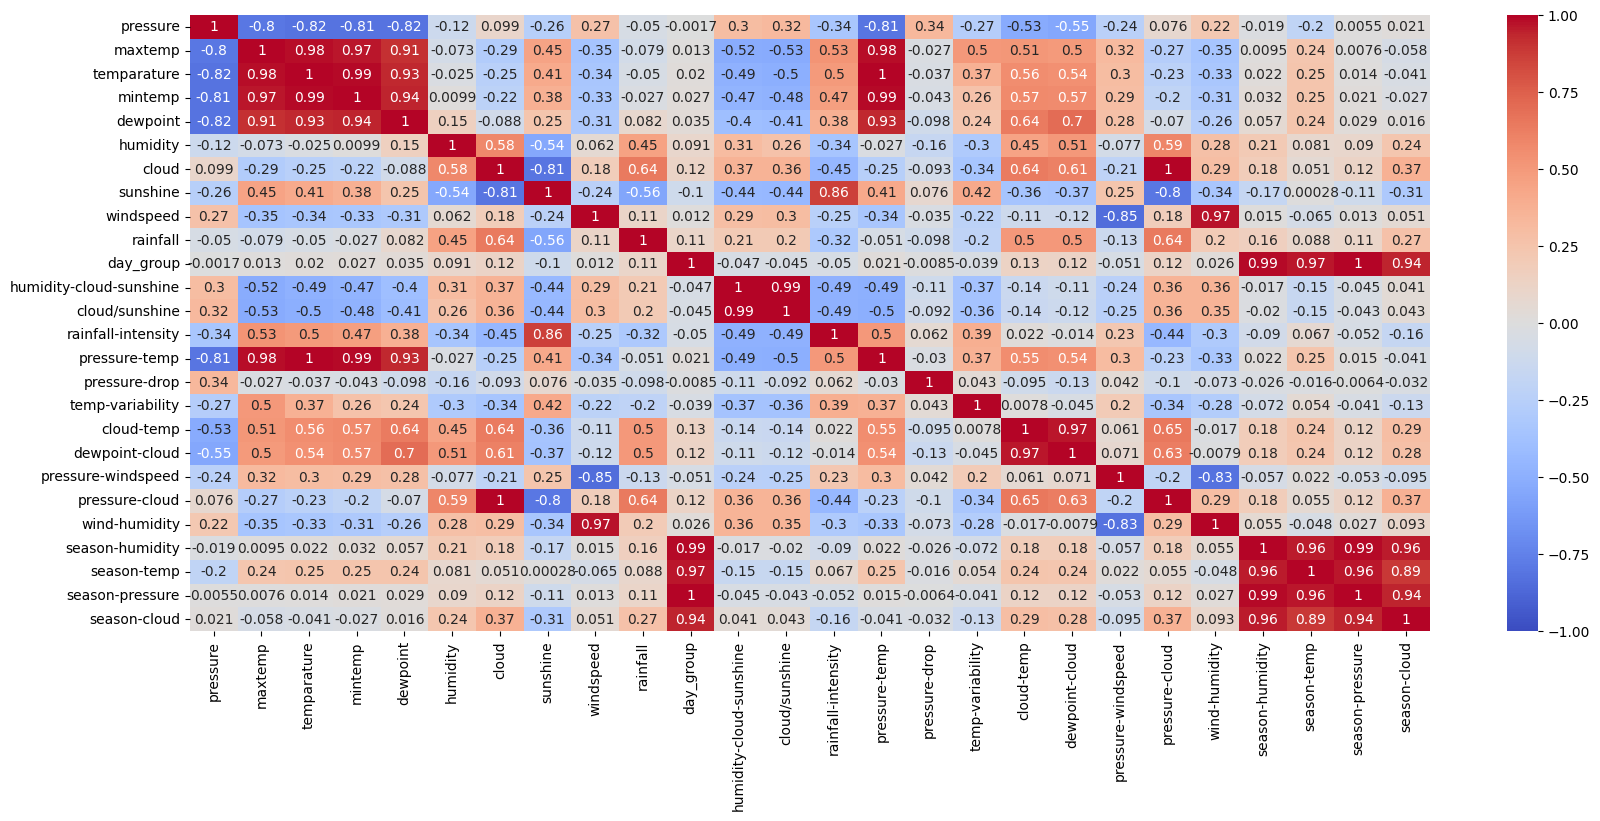

In [35]:
plt.figure(figsize=(20,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.show()

### Dropping features

pressure, maxtemp, mintemp, temperature, dewpoint, pressure-temp, pressure-drop, season-temp, windspeed, day_group, season-pressure

In [36]:
df.drop(["pressure", "maxtemp", "mintemp", "temparature", "dewpoint", "pressure-temp", "pressure-drop", "season-temp"], axis=1, inplace=True)
         # , , "windspeed", "day_group", "season-pressure"], axis=1, inplace=True)

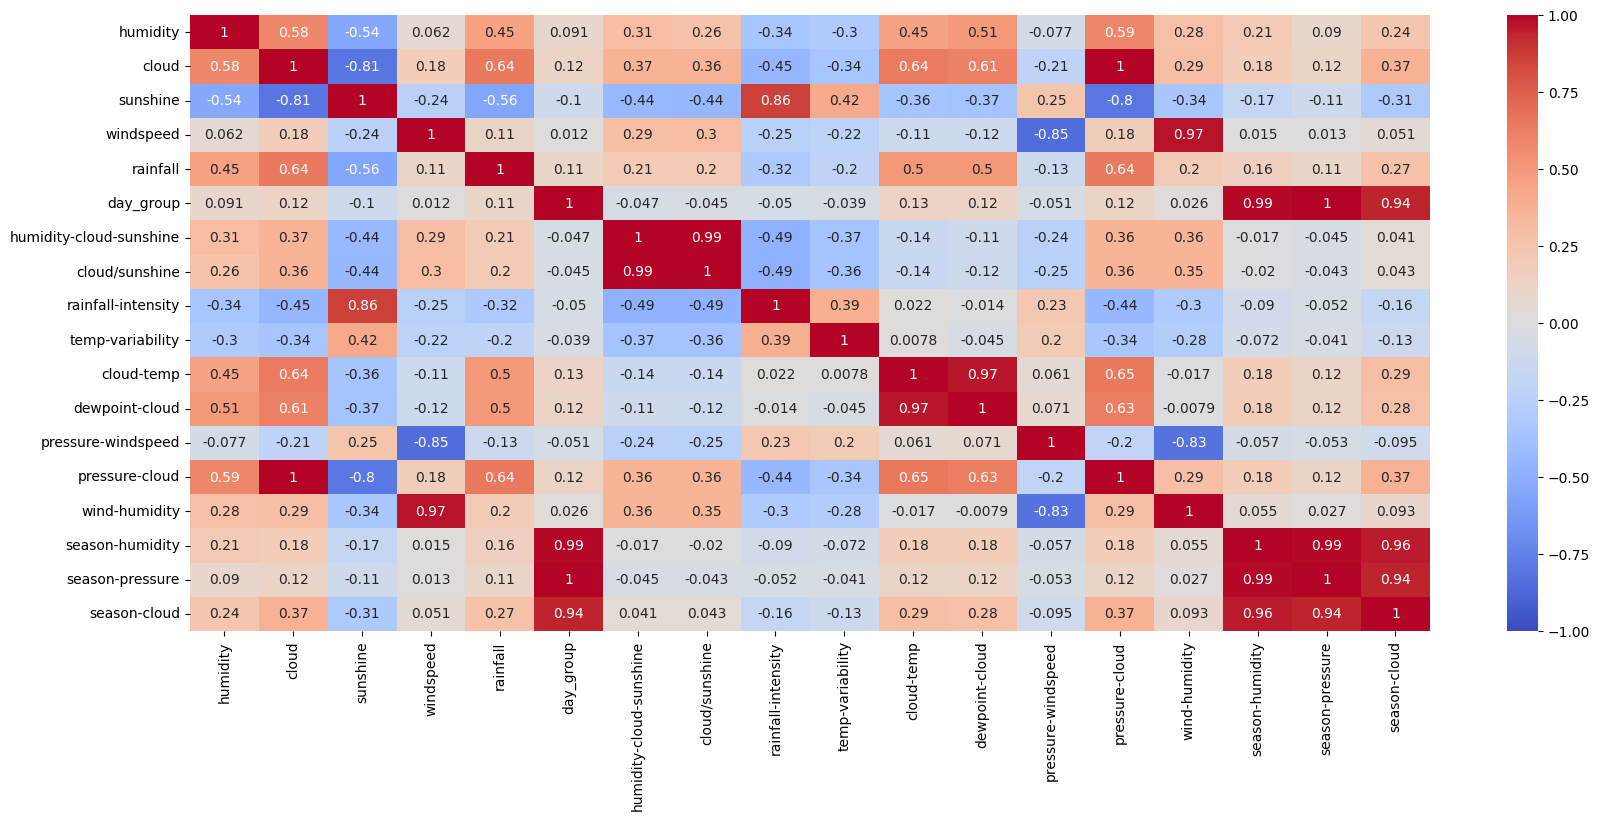

In [37]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.show()

### Test data

Follow the same feature engineering for test data

In [38]:
df_test["humidity-cloud-sunshine"] = (df_test["humidity"] * df_test["cloud"]) / (df_test["sunshine"] + 1e-6)
df_test["cloud/sunshine"] = df_test["cloud"] / (df_test["sunshine"] + 1e-6)
df_test["rainfall-intensity"] = (df_test["cloud"] * df_test["humidity"]) * (df_test["sunshine"] + 1e-6)

df_test["pressure-temp"] = df_test["pressure"] * df_test["temparature"]
df_test["pressure-drop"] = df_test["pressure"].diff()
df_test["temp-variability"] = df_test["maxtemp"] - df_test["mintemp"]
df_test["cloud-temp"] = df_test["cloud"] * df_test["temparature"]

df_test["dewpoint-cloud"]= df_test["dewpoint"] * df_test["cloud"]

df_test["pressure-windspeed"] = df_test["pressure"] / (df_test["windspeed"] + 1e-6)
                                                      
df_test["pressure-cloud"] = df_test["cloud"] / (df_test["pressure"] + 1e-6)
df_test["wind-humidity"] = df_test["windspeed"] * df_test["humidity"]

df_test["season-humidity"] = df_test["day_group"] * df_test["humidity"]
df_test["season-temp"] = df_test["day_group"] * df_test["temparature"]
df_test["season-pressure"] = df_test["day_group"] * df_test["pressure"]
df_test["season-cloud"] = df_test["day_group"] * df_test["cloud"]

In [39]:
df_test.drop(["pressure", "maxtemp", "mintemp", "temparature", "dewpoint", "pressure-temp", "pressure-drop", "season-temp"], axis=1, inplace=True)

# df_test.drop(["pressure", "maxtemp", "mintemp", "temparature", "dewpoint", "pressure-temp", "pressure-drop", "season-temp"], axis=1, inplace=True)

In [40]:
print(df.shape)
print(df_test.shape)

(2190, 18)
(730, 17)


In [41]:
X = df.drop("rainfall", axis=1)

In [42]:
Y = df["rainfall"]

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_test_scaled = scaler.transform(df_test)

In [44]:
X_scaled

array([[ 0.63643436,  0.68126858, -0.72939738, ..., -0.39836193,
        -0.449781  , -0.31346681],
       [ 1.66222368,  0.84772827, -1.03280391, ..., -0.31255894,
        -0.44791688, -0.28017965],
       [-0.90224963, -1.5936805 ,  1.25653632, ..., -0.52706642,
        -0.44383358, -0.76839142],
       ...,
       [-0.38935497,  0.18188951,  0.34631671, ...,  0.36313961,
         0.44606144,  0.46323373],
       [ 1.27755269,  0.95870139, -1.0052215 , ...,  0.64199933,
         0.4620396 ,  0.77391395],
       [ 0.89288169,  0.68126858, -0.75697979, ...,  0.57764708,
         0.44694912,  0.66295673]])

In [45]:
df_test_scaled

array([[ 1.79044735,  1.29162077, -1.03280391, ..., -0.30183357,
        -0.44791688, -0.19141387],
       [ 1.91867101,  1.29162077, -1.03280391, ..., -0.29110819,
        -0.45057991, -0.19141387],
       [ 0.50821069,  1.12516108, -1.03280391, ..., -0.4090873 ,
        -0.44401111, -0.22470104],
       ...,
       [ 1.27755269,  1.12516108, -1.03280391, ...,  0.64199933,
         0.46274974,  0.84048828],
       [ 1.53400002,  0.95870139, -1.03280391, ...,  0.68490082,
         0.44801433,  0.77391395],
       [-0.38935497,  0.73675514, -0.97763909, ...,  0.36313961,
         0.45955411,  0.68514817]])

In [46]:
Y

0       1
1       1
2       1
3       1
4       0
       ..
2185    1
2186    1
2187    1
2188    1
2189    1
Name: rainfall, Length: 2190, dtype: int64

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [48]:
x_train.shape

(1752, 17)

In [49]:
y_train.shape

(1752,)

In [50]:
x_train

array([[-0.38935497,  0.07091639,  0.23598706, ...,  1.21044414,
         1.32770107,  1.27322144],
       [ 1.14932902,  0.23737608, -1.03280391, ..., -0.35546044,
        -0.4530654 , -0.40223259],
       [-2.18448629, -1.37173425,  1.33928356, ...,  0.06282914,
         0.45263024, -0.15812671],
       ...,
       [-0.77402596, -0.37297612,  1.06345944, ..., -0.51634104,
        -0.45013607, -0.52428553],
       [-0.2611313 , -0.70589549,  0.84280014, ..., -1.33146945,
        -1.35290239, -1.28989035],
       [ 1.14932902,  0.51480889,  0.67730566, ...,  1.59655759,
         1.33009779,  1.53951877]])

In [51]:
# x_train = np.expand_dims(x_train, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)

In [52]:
y_train

162     1
1873    1
1366    0
554     0
964     0
       ..
1638    1
1095    1
1130    0
1294    1
860     1
Name: rainfall, Length: 1752, dtype: int64

In [53]:
model = Sequential([
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy']
             )

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, mode='min', min_lr=1e-5, verbose=1)

history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8311 - loss: 0.4051 - val_accuracy: 0.8562 - val_loss: 0.3970 - learning_rate: 0.0100
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8705 - loss: 0.3554 - val_accuracy: 0.8493 - val_loss: 0.3874 - learning_rate: 0.0100
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8622 - loss: 0.3321 - val_accuracy: 0.8493 - val_loss: 0.3970 - learning_rate: 0.0100
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8710 - loss: 0.3406 - val_accuracy: 0.8311 - val_loss: 0.3927 - learning_rate: 0.0100
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8619 - loss: 0.3395 - val_accuracy: 0.8562 - val_loss: 0.4097 - learning_rate: 0.0100
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8484 - loss: 0.3547 - val_accuracy: 0.8562 - val_loss: 0.3837 - learning_rate: 0.0100
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8711 - loss: 0.3463 - val_accuracy:

In [55]:
loss, accuracy = model.evaluate(x_test, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8637 - loss: 0.4059 


In [56]:
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.4f}%")

Loss: 0.3970
Accuracy: 85.6164%


### Predictions

Let's use this model to predict rainfall in the submission test dataset.

In [61]:
test_preds = model.predict(df_test_scaled).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [62]:
test_preds

array([0.8986266 , 0.9269705 , 0.78504264, 0.07744321, 0.09153006,
       0.7638556 , 0.80052704, 0.91382444, 0.8332454 , 0.61605203,
       0.911016  , 0.08058987, 0.92317903, 0.8280297 , 0.18464689,
       0.01387447, 0.7479817 , 0.6159327 , 0.09337945, 0.00994589,
       0.12926583, 0.1324699 , 0.70712173, 0.9434706 , 0.8818609 ,
       0.39752486, 0.01354509, 0.9128166 , 0.821459  , 0.39556307,
       0.7792964 , 0.80780005, 0.6660794 , 0.8896637 , 0.6741408 ,
       0.74373835, 0.14678097, 0.74405515, 0.66724855, 0.81073695,
       0.7447853 , 0.7136929 , 0.10778794, 0.7649466 , 0.7996413 ,
       0.1708265 , 0.13829018, 0.8650663 , 0.19449048, 0.7128271 ,
       0.8408371 , 0.89425683, 0.9051736 , 0.8665667 , 0.9121264 ,
       0.91039306, 0.76572335, 0.83187354, 0.797438  , 0.82192403,
       0.8129381 , 0.8751138 , 0.8638436 , 0.68872255, 0.2739735 ,
       0.31099296, 0.10575909, 0.7296287 , 0.7035334 , 0.09337261,
       0.9225414 , 0.7662599 , 0.7993779 , 0.8562782 , 0.87689

In [63]:
final_predictions = np.where(test_preds > 0.5, 1, 0)

In [64]:
final_predictions

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [65]:
final_submission_df = pd.DataFrame({"id": ids, "rainfall": final_predictions})
print(final_submission_df)

       id  rainfall
0    2190         1
1    2191         1
2    2192         1
3    2193         0
4    2194         0
..    ...       ...
725  2915         1
726  2916         1
727  2917         1
728  2918         1
729  2919         1

[730 rows x 2 columns]


In [105]:
final_submission_df.to_csv("submission-4.csv", index=False)
print("Successfully Saved")

Successfully Saved
